In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**DATA EXPLORATION**

Extracting Track Features

In [3]:
features = pd.read_csv("/content/drive/MyDrive/520final/data/track_features/tf_mini.csv")

Track features at a glance

In [4]:
features.head().T

,0,1,2,3,4
track_id,t_a540e552-16d4-42f8-a185-232bd650ea7d,t_67965da0-132b-4b1e-8a69-0ef99b32287c,t_0614ecd3-a7d5-40a1-816e-156d5872a467,t_070a63a0-744a-434e-9913-a97b02926a29,t_d6990e17-9c31-4b01-8559-47d9ce476df1
duration,109.707,187.693,160.84,175.4,369.6
release_year,1950,1950,1951,1951,1951
us_popularity_estimate,99.9754,99.9694,99.6025,99.665,99.9918
acousticness,0.45804,0.916272,0.812884,0.396854,0.728831
beat_strength,0.519497,0.419223,0.42589,0.400934,0.371328
bounciness,0.504949,0.54553,0.50828,0.35999,0.335115
danceability,0.399767,0.491235,0.491625,0.552227,0.483044
dyn_range_mean,7.51188,9.09838,8.36867,5.96735,5.80268
energy,0.817709,0.154258,0.358813,0.514585,0.721442


Summary Statistics

In [5]:
features.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,50704.0,222.267980,72.224839,30.013330,1.839333e+02,214.866669,250.426666,1787.760986
release_year,50704.0,2010.324748,11.471866,1950.000000,2.009000e+03,2015.000000,2017.000000,2018.000000
us_popularity_estimate,50704.0,99.455131,1.139222,90.018900,9.950967e+01,99.865444,99.961131,99.999997
acousticness,50704.0,0.250336,0.276047,0.000000,2.529069e-02,0.135821,0.406142,0.995796
beat_strength,50704.0,0.492075,0.158102,0.000000,3.743785e-01,0.493764,0.604994,0.990419
bounciness,50704.0,0.514526,0.182595,0.000000,3.724626e-01,0.522266,0.655912,0.972590
danceability,50704.0,0.611742,0.166146,0.000000,5.024992e-01,0.625145,0.736241,0.984952
dyn_range_mean,50704.0,8.215950,2.410626,0.000000,6.356671e+00,8.015075,9.792092,32.342781
energy,50704.0,0.641440,0.207957,0.000000,5.078394e-01,0.661368,0.803185,0.999877
flatness,50704.0,0.996548,0.045611,0.000000,9.759097e-01,1.003790,1.026137,1.103213


Separating Acoustic Features from other Features

In [6]:
all_features = features.T.to_numpy()
acoustic_vectors = all_features
acoustic_vectors[16] = np.array([1 if i == 'major' else 0 for i in all_features[16]])
other_features = acoustic_vectors[1:-8]
track_ids = acoustic_vectors[0]
track_id_list = list(track_ids)
acoustic_vectors = acoustic_vectors[-8:]

Loading Data

In [7]:
train_sess =  pd.read_csv("/content/drive/MyDrive/520final/data/training_set/train_try.csv")
test_sess =  pd.read_csv("/content/drive/MyDrive/520final/data/training_set/test_try.csv")

Extracting Session IDs

In [8]:
train_sess_ids = list(set(train_sess["session_id"]))
test_sess_ids = list(set(test_sess["session_id"]))

Session features at a glance

In [9]:
train_sess.head()

,Unnamed: 0,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end
0,0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
1,1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
2,2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
3,3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,20,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
4,4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,20,t_64f3743c-f624-46bb-a579-0f3f9a07a123,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone


In [10]:
test_sess.head()

,Unnamed: 0,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end
0,134303,0_0bca4bfb-5d25-4acf-8326-22ad4be7ddf0,1,20,t_a1cbcf29-5ff6-4a19-8d39-69dffe1f0878,False,False,False,True,0,0,0,0,0,0,False,15,2018-07-15,True,user_collection,clickrow,trackdone
1,134304,0_0bca4bfb-5d25-4acf-8326-22ad4be7ddf0,2,20,t_938c59d9-c6f8-475d-bb73-451446a19d8a,True,True,True,False,0,1,0,0,0,0,False,15,2018-07-15,True,user_collection,trackdone,fwdbtn
2,134305,0_0bca4bfb-5d25-4acf-8326-22ad4be7ddf0,3,20,t_04126a92-dfd5-4f9c-a426-78e1d906f2e5,True,True,True,False,0,1,0,0,0,0,False,15,2018-07-15,True,user_collection,fwdbtn,fwdbtn
3,134306,0_0bca4bfb-5d25-4acf-8326-22ad4be7ddf0,4,20,t_0b7562b7-e137-459f-96c7-7b088e4bd6d6,False,True,True,False,0,1,0,0,0,0,False,15,2018-07-15,True,user_collection,fwdbtn,endplay
4,134307,0_0bca4bfb-5d25-4acf-8326-22ad4be7ddf0,5,20,t_d65c8994-4d0c-4067-8d09-c180dd7330be,False,False,True,False,1,1,0,0,0,0,False,15,2018-07-15,True,user_collection,clickrow,endplay


Data Preprocessing

PCA with components = 8 Other Features

In [11]:
cov_mat = PCA(n_components = 21)
cov_mat.fit(other_features.T)

# Cumulative Sum of Variance explained with [n] features
variance = np.cumsum(np.round(cov_mat.explained_variance_ratio_, decimals = 3)*100)

In [12]:
print(variance)

[ 83.2  97.4  99.5  99.7  99.9 100.  100.  100.  100.  100.  100.  100.
 100.  100.  100.  100.  100.  100.  100.  100.  100. ]


Plot of Variance Explained (%) and Number of Features (#)

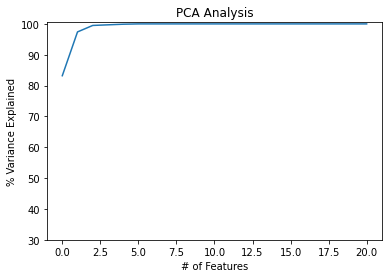

In [13]:
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')


plt.plot(variance)

PCA with components = 8 Acoustic Features

In [14]:
cov_mat = PCA(n_components = 8)
cov_mat.fit(acoustic_vectors.T)

# Cumulative Sum of Variance explained with [n] features
variance = np.cumsum(np.round(cov_mat.explained_variance_ratio_, decimals=3)*100)

In [15]:
print(variance)

[ 40.7  67.5  80.6  90.9  97.9  99.6  99.9 100. ]


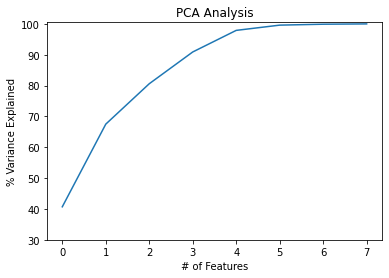

In [16]:
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')


plt.plot(variance)

PCA with components = 5 Other Features

In [17]:
pca = PCA(n_components=5)
other_feats_reduced = pca.fit_transform(other_features.T)
track_vector = np.concatenate((other_feats_reduced.T,acoustic_vectors)).T
print(track_vector.shape)

(50704, 13)


Restructuring Train and Test Data

In [18]:
train_len = len(train_sess_ids)
train_data_x = []
train_data_y = []
train_session_ids = []
total_count = 0
for i in range(train_len):
    temp_x = []
    temp_y = []
    sess_len = int(train_sess["session_length"][total_count])
    train_session_ids.append(train_sess["session_id"][total_count])
    for j in range(sess_len):
        temp_x.append(str(train_sess["track_id_clean"][j+total_count]))
        temp_y.append(int(train_sess["skip_2"][j+total_count]))
    train_data_x.append(temp_x)
    train_data_y.append(temp_y)
    total_count += sess_len

In [19]:
len(track_id_list)

50704

In [20]:
tr_x = []
tr_y = []
for i in range(len(train_data_x)):
    tr_skip_feats = np.zeros(13)
    tr_non_skip_feats = np.zeros(13)
    s_len = len(train_data_x[i])
    c_s = 0
    c_ns = 0
    for j in range(int(s_len/2)):
        if(train_data_y[i][j] == 0):
            tr_non_skip_feats = tr_non_skip_feats + track_vector[track_id_list.index(train_data_x[i][j])]
            c_ns += 1
        else:
            tr_skip_feats = tr_skip_feats + track_vector[track_id_list.index(train_data_x[i][j])]
            c_s += 1
    if(c_ns != 0):
        tr_non_skip_feats = tr_non_skip_feats/c_ns
    if(c_s != 0):
        tr_skip_feats = tr_skip_feats/c_s
    for j in range(int(s_len/2),s_len):
        tr_y.append(train_data_y[i][j])
        tr_x.append(np.concatenate((tr_skip_feats,tr_non_skip_feats,track_vector[track_id_list.index(train_data_x[i][j])])))

print(len(tr_x))
print(tr_x[0].shape)
print(len(tr_y))

68090
(39,)
68090


In [40]:
def make_average_feats(arr):
    arr = np.array(arr)
    n,m = arr.shape
    sum_list = np.zeros(m)
    for i in range(n):
        sum_list = sum_list + arr[i]
    return list(sum_list/n)

In [41]:
def form_final_feat_vector(feats,feats_length):
    if(len(feats)==0):
        return list(np.zeros(feats_length))
    return make_average_feats(feats)

In [44]:
track_ids = list(track_ids)
def preprocess(session_data,track_ids,track_vector):
    """
    Can be used to preprocess train/test data
    For every track in a particular session, find its track features from track_vector, 
    and get the average features for skipped and non-skipped tracks from the first half of the same session.
    Concat all the 3 with session features to get 43 final features.
    Input:
    Output: 
    """
    num_sess = len(list(set(session_data["session_id"])))
    data_x = []
    data_y = []
    total_count = 0
    i = 0
    while(i<num_sess):
        sess_len = int(session_data["session_length"][total_count])
        skipped_feats = []
        not_skipped_feats = []
        session_feats = []
        j = 0
        while j < (int(sess_len/2)):
            track_id = session_data["track_id_clean"][total_count+j]
            track_index = track_ids.index(track_id)
            track_features = list(track_vector[track_index])
            track_feature_length = len(track_features)
            if session_data["skip_2"][total_count+j] == True:
                skipped_feats.append(track_features)
            else :
                not_skipped_feats.append(track_features)
            if( j == (int(sess_len/2)) - 1 ):
                session_feats.append(int(session_data["premium"][total_count+j]))
                session_feats.append(int(session_data["hour_of_day"][total_count+j]/6))
                session_feats.append(int(session_data["hist_user_behavior_is_shuffle"][total_count+j]))
            j += 1
        skipped_feats = form_final_feat_vector(skipped_feats,track_feature_length)
        not_skipped_feats = form_final_feat_vector(not_skipped_feats,track_feature_length)
        while j < sess_len:
            track_id = session_data["track_id_clean"][total_count+j]
            track_index = track_ids.index(track_id)
            data_x.append([(j+1)/sess_len] + session_feats + skipped_feats + not_skipped_feats + list(track_vector[track_index]))
            data_y.append(int(session_data["skip_2"][total_count+j]))
            j +=1 
        total_count += sess_len
        i += 1
    return data_x,data_y

In [45]:
test_sess =  pd.read_csv("/content/drive/MyDrive/520final/data/training_set/test_try.csv")
train_sess = pd.read_csv("/content/drive/MyDrive/520final/data/training_set/train_try.csv")
tr_x,tr_y = preprocess(train_sess,track_ids,track_vector)
ts_x,ts_y = preprocess(test_sess,track_ids,track_vector)
print(len(tr_x),len(tr_y))
print(len(ts_x),len(ts_y))

68090 68090
17034 17034


In [48]:
np.save("/content/drive/MyDrive/520final/data/ts_x.npy", ts_x, allow_pickle=True)
np.save("/content/drive/MyDrive/520final/data/ts_y.npy", ts_y, allow_pickle=True)

In [49]:
np.save("/content/drive/MyDrive/520final/data/tr_x.npy", tr_x, allow_pickle=True)
np.save("/content/drive/MyDrive/520final/data/tr_y.npy", tr_y, allow_pickle=True)

In [50]:
tr_x = np.load("/content/drive/MyDrive/520final/data/tr_x.npy",allow_pickle=True)
tr_y = np.load("/content/drive/MyDrive/520final/data/tr_y.npy",allow_pickle=True)

ts_x = np.load("/content/drive/MyDrive/520final/data/ts_x.npy",allow_pickle=True)
ts_y = np.load("/content/drive/MyDrive/520final/data/ts_y.npy",allow_pickle=True)

In [51]:
ts_x.shape

(17034, 43)

In [55]:
tr_x.shape


(68090, 43)

**MODEL WALK-THROUGH**

Analysis

Function for Extracting Session Lengths

In [23]:
def session_lengths(test_sess):
  test_sess_ids = list(set(test_sess["session_id"]))
  test_len = len(test_sess_ids)
  sess_lens = []
  total_count = 0
  i = 0
  while(i < test_len ):
      sess_len = int(test_sess["session_length"][total_count])
      sess_lens.append(math.ceil(sess_len/2))
      total_count += sess_len
      i += 1
  return sess_lens

In [24]:
test_sess_lens = session_lengths(test_sess)
train_sess_lens = session_lengths(train_sess)

In [25]:
def process(test_data,sess_lens):
    res = []
    i = 0
    for sess_len in sess_lens:
        res.append(test_data[i:i+sess_len])
        i = i+sess_len
    return res

Evaluation

In [26]:
def evaluate(submission,groundtruth):
    ap_sum = 0.0
    first_pred_acc_sum = 0.0
    counter = 0
    for sub, tru in zip(submission, groundtruth):
        ap_sum += ave_pre(sub,tru,counter)
        first_pred_acc_sum += sub[0] == tru[0]
        counter+=1
    ap = ap_sum/counter
    first_pred_acc = first_pred_acc_sum/counter
    return ap,first_pred_acc

Average Predictions

In [27]:
def ave_pre(submission,groundtruth,counter):
    s = 0.0
    t = 0.0
    c = 1.0
    for x, y in zip(submission, groundtruth):
        if x != 0 and x != 1:
            raise Exception('Invalid prediction in line {}, should be 0 or 1'.format(counter))
        if x==y:
            s += 1.0
            t += s / c
        c += 1
    return t/len(groundtruth)

Simple Baseline

In [28]:
pred_0 = np.zeros((ts_y.shape[0]))
pred_1 = pred_0 + 1

In [29]:
accuracy = accuracy_score(ts_y, pred_0)
print("Accuracy for all labelled as Not Skipped: %.2f%%" % (accuracy * 100.0))

Accuracy for all labelled as Not Skipped: 47.95%


In [30]:
accuracy = accuracy_score(ts_y, pred_1)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 52.05%


Strong Baseline

In [31]:
def cos_sim(vA,vB):
  return np.dot(vA, vB) / (np.sqrt(np.dot(vA,vA)) * np.sqrt(np.dot(vB,vB)) + 0.0001)

In [32]:
base_pred = np.zeros(ts_x.shape[0])
for i in range(len(ts_x)):
  skip = ts_x[i][4:17]
  not_skip = ts_x[i][17:30]
  current = ts_x[i][30:]
  flag = 0
  if(cos_sim(skip, current) > cos_sim(not_skip, current)):
    flag = 1
  base_pred[i] = flag

In [33]:
predictions = [round(value) for value in base_pred]
accuracy = accuracy_score(ts_y, predictions)
MAA, FPR = evaluate(process(predictions,test_sess_lens),process(ts_y,test_sess_lens))
print("Sklearn Accuracy: %.2f%%" % (accuracy * 100.0))
print("MAA Accuracy: %.2f%%" % (MAA * 100.0))
print("FPR Accuracy: %.2f%%" % (FPR * 100.0))

Sklearn Accuracy: 50.95%
MAA Accuracy: 35.30%
FPR Accuracy: 53.57%


XGBoost

In [56]:
model = XGBClassifier(max_depth=2, n_estimators=100)
model.fit(tr_x, tr_y)

XGBClassifier(max_depth=2)

Predictions

In [57]:
y_pred = model.predict(ts_x)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(ts_y, predictions)
MAA, FPR = evaluate(process(predictions,test_sess_lens),process(ts_y,test_sess_lens))
print("Sklearn Accuracy: %.2f%%" % (accuracy * 100.0))
print("MAA Accuracy: %.2f%%" % (MAA * 100.0))
print("FPR Accuracy: %.2f%%" % (FPR * 100.0))

Sklearn Accuracy: 59.89%
MAA Accuracy: 48.15%
FPR Accuracy: 62.56%


Random Forest

In [58]:
model = RandomForestClassifier(max_depth=9, n_estimators=125)
model.fit(tr_x, tr_y)

RandomForestClassifier(max_depth=9, n_estimators=125)

Predictions

In [59]:
y_pred = model.predict(ts_x)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(ts_y, predictions)
MAA, FPR = evaluate(process(predictions,test_sess_lens),process(ts_y,test_sess_lens))
print("Sklearn Accuracy: %.2f%%" % (accuracy * 100.0))
print("MAA Accuracy: %.2f%%" % (MAA * 100.0))
print("FPR Accuracy: %.2f%%" % (FPR * 100.0))

Sklearn Accuracy: 59.38%
MAA Accuracy: 47.40%
FPR Accuracy: 61.01%


10 Classifier Approach

In [60]:
X_3D = []
y_2D = []
for i in range(10):
  X_3D.append([])
  y_2D.append([])
tot = 0
for i in train_sess_lens:
  for j in range(i):
    X_3D[j].append(tr_x[tot + j])
    y_2D[j].append(tr_y[tot + j])
  tot += i

In [61]:
def classifiers(X_3D, y_2D):
  models = []
  for i in range(10):
    clf = XGBClassifier(n_estimators=100,max_depth=2)
    clf.fit(np.array(X_3D[i]), np.array(y_2D[i]))
    models.append(clf)
  return models

In [62]:
models = classifiers(X_3D,y_2D)

In [63]:
def predict_classifier(ts_x, models):
  tot = 0
  y_pred = []
  for i in test_sess_lens:
    for j in range(i):
      y_pred.append(models[j].predict([ts_x[tot + j]])[0])
    tot += i
  return y_pred

In [64]:
y_pred = predict_classifier(ts_x,models)

In [65]:
accuracy = accuracy_score(ts_y, y_pred)
MAA, FPR = evaluate(process(y_pred,test_sess_lens),process(ts_y,test_sess_lens))
print("Sklearn Accuracy: %.2f%%" % (accuracy * 100.0))
print("MAA Accuracy: %.2f%%" % (MAA * 100.0))
print("FPR Accuracy: %.2f%%" % (FPR * 100.0))

Sklearn Accuracy: 60.56%
MAA Accuracy: 47.55%
FPR Accuracy: 60.96%


Taking the input of the last played track in training data (whether it was skipped or not)

In [66]:
St0s = np.load("/content/drive/MyDrive/520final/data/St0s.npy",allow_pickle=True)

In [67]:
def inverse_process(St0s,sess_lens):
    res = []
    i = 0
    for val,sess_len, in zip(St0s,sess_lens):
        for i in range(sess_len):
            res.append(val)
    return res

In [68]:
def set_threshold(pred):
    if flag == 0:
        if(pred>0.5):
            return 1
        else:
            return 0
    else:
        if(pred>=0.5):
            return 1
        else:
            return 0

In [69]:
def predict_sol_2(ts_x, models):
  tot = 0
  y_pred = []
  for i in test_sess_lens:
    for j in range(i):
        pred = models[j].predict([ts_x[tot + j]])[0]
        y_pred.append(set_threshold(pred*0.5 + 0.5*St0s[tot + j]))
    tot += i
  return y_pred

In [70]:
y_pred = predict_sol_2(ts_x,models)
accuracy = accuracy_score(ts_y, y_pred)
MAA, FPR = evaluate(process(y_pred,test_sess_lens),process(ts_y,test_sess_lens))
print("Sklearn Accuracy: %.2f%%" % (accuracy * 100.0))
print("MAA Accuracy: %.2f%%" % (MAA * 100.0))
print("FPR Accuracy: %.2f%%" % (FPR * 100.0))

Sklearn Accuracy: 64.08%
MAA Accuracy: 53.45%
FPR Accuracy: 71.89%


In [71]:
def predict_sol_3(ts_x, models):
  tot = 0
  y_pred = []
  for i in test_sess_lens: #all
    for j in range(i): #models
        pred = models[j].predict([ts_x[tot + j]])[0]
        if(j == 0 ):
            y_pred.append(set_threshold(pred*0.5 + 0.5*St0s[tot + j]))
        else:
           y_pred.append(set_threshold(pred*0.5 + 0.5*y_pred[-1])) 
    tot += i
  return y_pred
y_pred = predict_sol_3(ts_x,models)
accuracy = accuracy_score(ts_y, y_pred)
MAA, FPR = evaluate(process(y_pred,test_sess_lens),process(ts_y,test_sess_lens))
print("Sklearn Accuracy: %.2f%%" % (accuracy * 100.0))
print("MAA Accuracy: %.2f%%" % (MAA * 100.0))
print("FPR Accuracy: %.2f%%" % (FPR * 100.0))

Sklearn Accuracy: 62.82%
MAA Accuracy: 52.76%
FPR Accuracy: 71.89%
